# Bag of Words and NBGaussian Jeopardy! solver

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk

from pandas import Series, DataFrame

plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from datasets import load_dataset

# Load jeopardy dataset
jeopardy = load_dataset('jeopardy')

Using custom data configuration default
Reusing dataset jeopardy (/Users/cade/.cache/huggingface/datasets/jeopardy/default/0.1.0/0430048e0bdfcd0dfe0ccb1138b14276e63afd19af84d57338e2ca837590ac1c)


In [3]:
# Load all of the Jeopardy! data
j = pd.DataFrame(jeopardy['train'])

In [4]:
# Remove extraneous data...
j = j.drop(columns=['air_date', 'show_number', 'round', 'value', 'category'])
j

,answer,question
0,Copernicus,"'For the last 8 years of his life, Galileo was..."
1,Jim Thorpe,'No. 2: 1912 Olympian; football star at Carlis...
2,Arizona,'The city of Yuma in this state has a record a...
3,McDonald\'s,"'In 1963, live on ""The Art Linkletter Show"", t..."
4,John Adams,"'Signer of the Dec. of Indep., framer of the C..."
...,...,...
216925,Turandot,'This Puccini opera turns on the solution to 3...
216926,a titmouse,'In North America this term is properly applie...
216927,Clive Barker,"'In Penny Lane, where this ""Hellraiser"" grew u..."
216928,Geronimo,"'From Ft. Sill, Okla. he made the plea, Arizon..."


# Preprocessing
- Strip all punctuation
- Make everything lowercase
- Remove whitespace
- Remove video clues (either have a URL to a video or say "clue crew" because they need a visual)
- Remove answers that are empty
- Remove stop words

In [5]:
j.answer = (j.answer
                .str.strip()
                .str.lower()
           )
j.question = (j.question
                 .str.strip()
                 .str.lower()
             )
j

,answer,question
0,copernicus,"'for the last 8 years of his life, galileo was..."
1,jim thorpe,'no. 2: 1912 olympian; football star at carlis...
2,arizona,'the city of yuma in this state has a record a...
3,mcdonald\'s,"'in 1963, live on ""the art linkletter show"", t..."
4,john adams,"'signer of the dec. of indep., framer of the c..."
...,...,...
216925,turandot,'this puccini opera turns on the solution to 3...
216926,a titmouse,'in north america this term is properly applie...
216927,clive barker,"'in penny lane, where this ""hellraiser"" grew u..."
216928,geronimo,"'from ft. sill, okla. he made the plea, arizon..."


In [6]:
# Remove punctuation
regex = r'[-\,()\"#\/@;:<>\{\}!\-=~|\.\?\&+^%$_\'\*\\]'
j = j.replace(to_replace=regex, value="", regex=True)

# Drop video clues (contains clue crew or href)
j = j.loc[j.question.str.contains("clue crew") == False]
j = j.loc[j.question.str.contains("href") == False]

# example
j[j['answer'] == "jfk"]

,answer,question
19635,jfk,his library is located on the columbia point p...
20262,jfk,kingsizemaybes song dallas recalls the day of ...
20861,jfk,meg ryan was in iq with walter matthau who was...
38442,jfk,he was the youngest man elected president sad...
39173,jfk,were he still alive this president would now b...
39714,jfk,in 1963 he famously remarked all free men wher...
45101,jfk,cliff robertson br in pt 109
59826,jfk,kevin costner chases assassination conspirators
84170,jfk,in the solomons you can tour olasana island wh...
99892,jfk,may 29 1917 in brookline massachusetts


## Processing for NLP
I followed [this guide](https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908) by Olga Davydova on Medium and the NLP lecture from the CSCI303 TA's for most of this text clean up.

In [7]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#nltk.download('punkt')
#nltk.download('wordnet')

In [8]:
from nltk.stem import PorterStemmer
stop_words = set(stopwords.words('english'))


def tokenize(entry):
    return word_tokenize(entry)


def remove_stop_words(entry):
    """ Removes stop words given a row from a dataframe"""
    return [i for i in entry if not i in stop_words]


def lemma(entry):
    """Lemmatize all of the words of each entry...defaulting to noun lemmatization"""
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in entry]


def clean(entry):
    entry = tokenize(entry)
    entry = remove_stop_words(entry)
    entry = lemma(entry)
    
    # TODO: decide if stemming makes anything better...
    #entry = stem(entry)
    return " ".join(entry)


def stem(entry):
    ps = PorterStemmer()
    return [ps.stem(word) for word in entry]

# Tokenize, remove stop words, and lemmatize
j['clean'] = j.apply(lambda row: clean(row['question']), axis=1)
j

,answer,question,clean
0,copernicus,for the last 8 years of his life galileo was u...,last 8 year life galileo house arrest espousin...
1,jim thorpe,no 2 1912 olympian football star at carlisle i...,2 1912 olympian football star carlisle indian ...
2,arizona,the city of yuma in this state has a record av...,city yuma state record average 4055 hour sunsh...
3,mcdonalds,in 1963 live on the art linkletter show this c...,1963 live art linkletter show company served b...
4,john adams,signer of the dec of indep framer of the const...,signer dec indep framer constitution mass seco...
...,...,...,...
216925,turandot,this puccini opera turns on the solution to 3 ...,puccini opera turn solution 3 riddle posed her...
216926,a titmouse,in north america this term is properly applied...,north america term properly applied 4 specie c...
216927,clive barker,in penny lane where this hellraiser grew up th...,penny lane hellraiser grew barber shave anothe...
216928,geronimo,from ft sill okla he made the plea arizona is ...,ft sill okla made plea arizona land home fathe...


### Lemmatization constraints
The NLTK WordNet Lemmatizer defaults to noun lemmatization, so conjugations of verbs (e.g., "becomes" and "became" --> "become") will not be lemmatized. 

In the future, I would like to explore other lemmatizer libraries (like Gensim) that work better with an unknown part of speech.

---
## Data exploration

In [9]:
group = j.groupby('answer')
group.first()

,question,clean
answer,,
,of the 4 presidents pictured here [rest of clu...,4 president pictured [ rest clue unavailable ]
the mysterians,their 96 tears punctuated the charts in 1966,96 tear punctuated chart 1966
i before e except after c,eye ebr see exceptbr br its a mnemonic devic...,eye ebr see exceptbr br mnemonic device help r...
then,popular in geometry as in logic are statements...,popular geometry logic statement known
0,water freezes into ice at 32 degrees fahrenhei...,water freeze ice 32 degree fahrenheit many deg...
...,...,...
été,a season br tee,season br tee
île de la cité,the 2 islands in the heart of paris are the il...,2 island heart paris ile saintlouis one notre ...
über,german prefix for beyond over or super,german prefix beyond super


In [10]:
# Count unique values
unique = j.answer.value_counts().to_frame()

# Compare common answers to the number of times they have been asked
unique.rename(columns={"answer":"answer frequency"})

,answer frequency
china,209
australia,208
chicago,189
japan,187
france,187
...,...
indulge,1
bon vivant,1
nunchaku or numchucks,1
an arm,1


There are around 71,000 unique answers in the dataset, but many of them are rare: there are 209 clues about China, but only one clue for most of the answers in the set. 

For model fitting purpose, I will not train on clue answers that are rare. 

In [11]:
unique = unique.answer.value_counts().to_frame()
unique = unique.reset_index().rename(columns={"index":"clue_appearances", "answer":"number_of_clues"})
unique

,clue_appearances,number_of_clues
0,1,43814
1,2,10829
2,3,5125
3,4,2875
4,5,1961
...,...,...
122,148,1
123,84,1
124,209,1
125,208,1


In the above dataframe, note that there are >43000 such clues that only have one sample. Removing clues that appear less than 5-10 times will increase the accuracy of the model at the expense of breadth. 

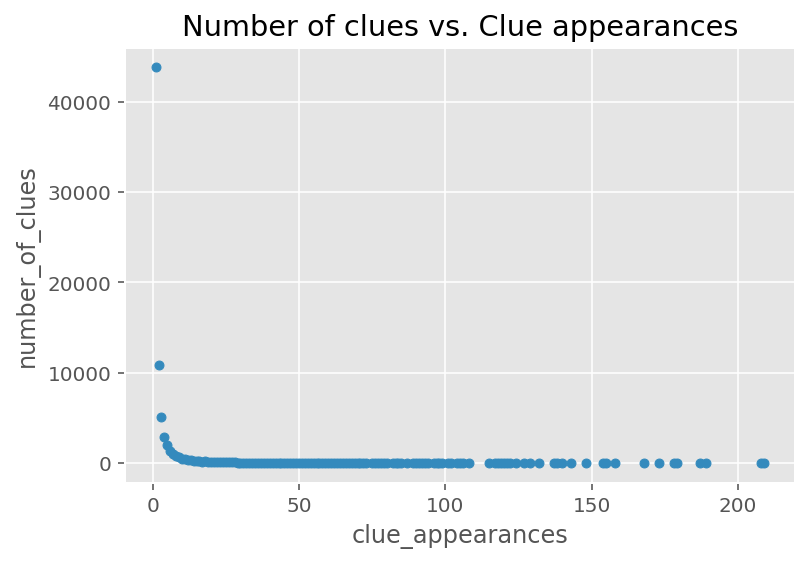

In [12]:
unique.plot(kind='scatter', x="clue_appearances", y="number_of_clues")
plt.title("Number of clues vs. Clue appearances")
plt.show()

The above chart plots how many clues have been asked a certain number of times. For example, there is only one clue that has been asked 209 times, China (bottom right point), while there are over 40,000 clues that have been asked about only once (top left point).

Most of the clues in this data set are unique (~43k answers have only been seen once), so these should be excluded from the dataset. Many of the clues that have only appeared once or twice are word play like "the good, the bad, and the ugly duckling" or rare answers that would be difficult to predict accurately with such a small sampling (like "things with chains," "grandma and grandpa"). 

The plot below removes some of the rarer clues to show a more accurate distribution of clue frequency vs. number of samples

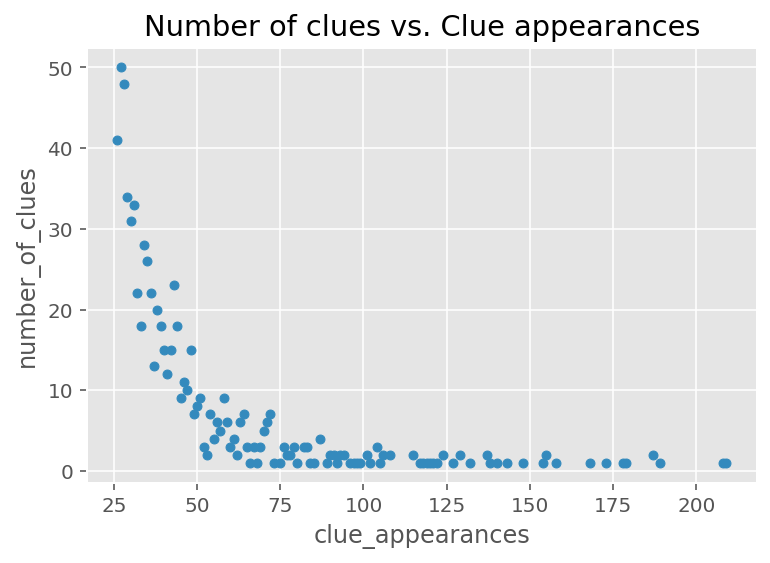

In [17]:
unique[unique.clue_appearances > 25].plot(kind='scatter', x="clue_appearances", y="number_of_clues")
plt.title("Number of clues vs. Clue appearances")
plt.show()

# Representing data with bag of words

I followed a simple methodology for extracting meaning from each clue called bag of words. Bag of words is a form of feature extraction that represents the content of each clue by using the frequency of each word's appearance as an entry of a vector. 

For example, the sentence "the dog and the cat both like dog food" could be turned into the following vector representation, where the integer represents the frequency of that word in the sentence. 
```pseudocode
{ "the" : 2,
  "dog" : 2,
  "and" : 1,
  "cat" : 1,
  "both" : 1,
  "like" : 1,
  "food" : 1
}
  
```
If we used a larger vocabulary (e.g., all of the words that have occured in a Jeopardy clue), we could apply this vectorization to each clue sequentially and represent features of the text. Each clue has to be represented using the same ordered vocabulary (the length of each vector == the number of words in vocabulary), so they will be sparse and contain a lot of zero scores.

This is the framework I followed for my methodology from [NLP Project Using Bag-of-Words](https://in.springboard.com/blog/nlp-project-automated-question-answering-model/)

>The bag-of-words model represents the text as a multiset of words. In essence, it’s exactly as the name suggests — it is a bag of individual words, without taking into account the word order or grammar. To perform retrieval using the bag-of-words in an NLP model, we typically follow these steps:
>
>- Break the dataset into individual words
>- Make a dictionary of the words
>- Print the dictionary
>- Create a bag-of-words corpus, from which you can make a sparse representation for each sentence
>- Get bag-of-words representation for a user query
>- Loop over all the question vectors created and perform a cosine similarity function with the query vector
>- When you use this model, you’ll be comparing the exact words in your query sentence and FAQs to identify similarities. This means that the bag-of-words model doesn’t process underlying meaning or context, resulting in inaccurate results.

**Other references in this section**
- https://machinelearningmastery.com/gentle-introduction-bag-words-model/

In [32]:
# Filter out the answers that don't appear frequently enough
# https://stackoverflow.com/questions/49137031/pandas-dataframe-delete-rows-with-low-frequency

min_samples = 30

j = j[j.groupby('answer')['answer'].transform('count').ge(min_samples)]
j = j.rename(columns={'question': 'original_question', 'answer':'original_answer', 'clean':'clean_text'})

In [33]:
j

,original_answer,original_question,clean_text
2,arizona,the city of yuma in this state has a record av...,city yuma state record average 4055 hour sunsh...
3,mcdonalds,in 1963 live on the art linkletter show this c...,1963 live art linkletter show company served b...
4,john adams,signer of the dec of indep framer of the const...,signer dec indep framer constitution mass seco...
7,michael jordan,no 8 30 steals for the birmingham barons 2306 ...,8 30 steal birmingham baron 2306 steal bull
8,washington,in the winter of 197172 a record 1122 inches o...,winter 197172 record 1122 inch snow fell raini...
...,...,...,...
216904,ronald reagan,in 1981 he quipped you can tell a lot about a ...,1981 quipped tell lot fellow character way eat...
216905,budapest,it has a museum devoted to composer zoltan kodaly,museum devoted composer zoltan kodaly
216906,amsterdam,red light winter centers on a love triangle th...,red light winter center love triangle begin fa...
216910,muhammad ali,in his prime this athlete said its hard to be ...,prime athlete said hard humble youre great


Here, I'll define the set of words that form the vocabulary and will be used to vectorize each clue.

In [34]:
# Define vocabulary 
vocabulary = set()
j.clean_text.str.split().apply(vocabulary.update)
vocabulary

{'disappears',
 'star',
 'babrak',
 'lugano',
 'ec',
 'bravely',
 'latitude',
 'secondclosest',
 'fraktur',
 'desertification',
 'kailua',
 'aborigine',
 'extreme',
 '442',
 'numberbr',
 'higgledy',
 'marry',
 'aldous',
 'stanwyck',
 'froufrous',
 'aroma',
 'bassetto',
 'alkmaar',
 '12300',
 'pali',
 'leaguers',
 'degenerate',
 'valmeuse',
 'calcutta',
 'loeil',
 'longer',
 'foot',
 'whisker',
 'roda',
 'obstinate',
 'marhaba',
 'prudhoe',
 'jaune',
 'vision',
 'manu',
 'bananarama',
 'emirate',
 'switzerlandbr',
 'paranoiabr',
 'nebuchadnezzar',
 'thrushcross',
 'wausau',
 'bonneville',
 'infection',
 'greatest',
 'yee',
 'happy',
 'grisnez',
 'knowim',
 'isolationism',
 'irrelevant',
 'huck',
 'cultured',
 'crossable',
 'gesplit',
 'unique',
 'politechnico',
 'lift',
 'soy',
 'lass',
 'ww2',
 'serial',
 'gruyere',
 'enough',
 'anchored',
 'treasurer',
 'demigod',
 'simferopol',
 'whakarewarewa',
 'statist',
 'hypothesis',
 'january',
 'glitch',
 'fling',
 'pericles',
 'adamsbr',
 'ga

To increase the accuracy of the model, I want to combine all of the training clues into a single vector, so I am going to split my data into training and testing sets. 

With the training data, I want to concatenate each training clue into one prompt, prior to vectorizing.

In [38]:
# Train-test-split!
from sklearn.model_selection import train_test_split

train, test = train_test_split(j, test_size=0.1)
train.shape, test.shape

((26755, 3), (2973, 3))

In [39]:
# Smash answers together to create lookup table with BoW for the train set
# e.g., all of the questions about China should be described by one vector
train = pd.DataFrame(train.groupby('original_answer')['clean_text'].apply(' '.join))
train

,clean_text
original_answer,
1,number leg one monopods narnia book order blin...
10,square root 100 make men lacrosse team need ma...
12,musical note schoenberg atonal scale canadian ...
13,apollo lunar mission number aborted en route m...
1984,mary lou retton olympic gymnastic gold los ang...
...,...
yale,founded 1701br lock company mayhap youll join ...
yellow,wax bean variety green bean thats color dandel...
zachary taylor,alphabetically first name he listed last exhum...


### TF-IDF for vectorization
$\mathrm{TF-IDF}$ (or term frequency-inverse document frequency) is a measure that better accounts for the weight of rare words. The $\mathrm{TF-IDF}$ value for a word increases with its frequency (term frequency), but it is offset by its popularity in other clues (inverse document frequency).

In other words, we can choose to give weight to more meaningful words using $\mathrm{TF-IDF}$, as opposed to just measuring term frequency. When two documents share a rare word (e.g., 'Mugabe'), it is a more meaningful link than sharing a common word (e.g., 'woman'). 

In [46]:
# Create BoW vectors for each set of data

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


def create_vectors(df, col, vocabulary, is_dense=True, use_tfidf=True):
    """Creates vectors for a given column of a dataframe.
            Parameters:
                df (DataFrame): a dataframe
                col (string): name of a column in dataframe
                vocabulary (iterable): set of words for vectorization
                is_dense (boolean, optional): default returns a dense matrix, 
                        False returns csr_matrix
                use_tfidf (boolean, optional): default uses tf-idf for vectorization, 
                        False uses tf only
            Returns:
                vectors: a dataframe of sparse/dense vectors
    """
    
    if use_tfidf:
        vectorizer = TfidfVectorizer(vocabulary=vocabulary)
        X = vectorizer.fit_transform(df[col])
    else: 
        # Vectorize using CountVectorizer
        vectorizer = CountVectorizer(vocabulary=vocabulary)
        X = vectorizer.fit_transform(df[col])
        
    if is_dense:
        # output vectors should be dense
        vectors = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())
    else: 
        vectors = pd.DataFrame(X, columns=['vec'])
    return vectors

In [47]:
# create bag of words for the Training set
train_vectors = create_vectors(train, 'clean_text', vocabulary)

# reset vectors on jeopardy so they align correctly
train = train.reset_index().rename(columns={'index':'q_id'})

# Concat the vectors to the right side of the train! dataframe
# pd.concat(..., ignore_index=True) isn't working how I expect?
train = pd.concat([train, train_vectors], axis=1)

In [48]:
# repeat above process for the test set
test_vectors = create_vectors(test, 'clean_text', vocabulary) 

test = test.reset_index().rename(columns={'index':'q_id'})

test = pd.concat([test, test_vectors], axis=1)

In [50]:
test = test.drop(columns=['clean_text', 'q_id'])
test

,original_answer,original_question,0,0000br,004,00601,00698,007,01,02,...,¿donde,édouard,‘,’,“,”,…as,…he,…take,…to
0,gold,king midas almost died of hunger because every...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,green,lets dramatize your look with some hard candy ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,new zealand,the strait between this countrys 2 main island...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,new york,charles rangelbr sherwood boehlertbr carolyn m...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,nixon,five years ago our college campuses were a bat...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2968,nashville,music city usa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2969,greece,for some chic shopping great beaches visit my...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2970,the wizard of oz,chapter 8 of this popular l frank baum work is...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2971,rio de janeiro,people in this south american city were upset ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model classification using Gaussian Naive Bayes

Naive Bayes classifiers use Bayes's theorem to describe the probability of events and assign class labels to samples. I chose to use the Gaussian Naive Bayes model because it works well with text data. While I don't go into the math behind it, it is pretty interesting.

I originally tried to use cosine similarity to measure the similarity between vectors, but I faced challenges with using a sparse matrix representation, long runtime & running out of memory, and calculating meaningful differences in each word's vector representation. Cosine similarity is a widely accepted measurement for phrase similarity with bag of words vectors, but I couldn't get it to work.

Framing this problem as a form of classification and using Gaussian Naive Bayes opened up the most room for finding and evaluating results. The cell below will train the classifier and make predictions, but it takes my computer around 10-15 minutes to train on this dataset. 

**References:**
- [Text classification using the Bag Of Words Approach with NLTK and Scikit Learn](https://medium.com/swlh/text-classification-using-the-bag-of-words-approach-with-nltk-and-scikit-learn-9a731e5c4e2f)
- [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)

In [148]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_hat)
print("Model accuracy:", accuracy * 100)

Model accuracy: 40.73326606121763


In [234]:
from sklearn.metrics import classification_report
classification_report = classification_report(y_test, y_hat, output_dict=True, zero_division=0)
cr = pd.DataFrame(classification_report).T
cr = cr.reset_index()

precision_avg = cr.loc[559]['precision']
recall_avg = cr.loc[559]['recall']
f1_avg = cr.loc[559]['f1-score']


cr = cr.iloc[:-3]  ## drop metadata
print(precision_avg, recall_avg, f1_avg)
cr

0.4569646683094189 0.4487984036826791 0.403362729844521


,index,precision,recall,f1-score,support
0,1,0.000000,0.000000,0.000000,5.0
1,10,0.000000,0.000000,0.000000,2.0
2,12,0.000000,0.000000,0.000000,1.0
3,13,0.500000,0.333333,0.400000,3.0
4,1984,0.666667,0.571429,0.615385,7.0
...,...,...,...,...,...
553,yale,0.400000,0.666667,0.500000,3.0
554,yellow,0.500000,0.200000,0.285714,5.0
555,zachary taylor,0.200000,0.500000,0.285714,2.0
556,zeus,0.166667,0.666667,0.266667,3.0


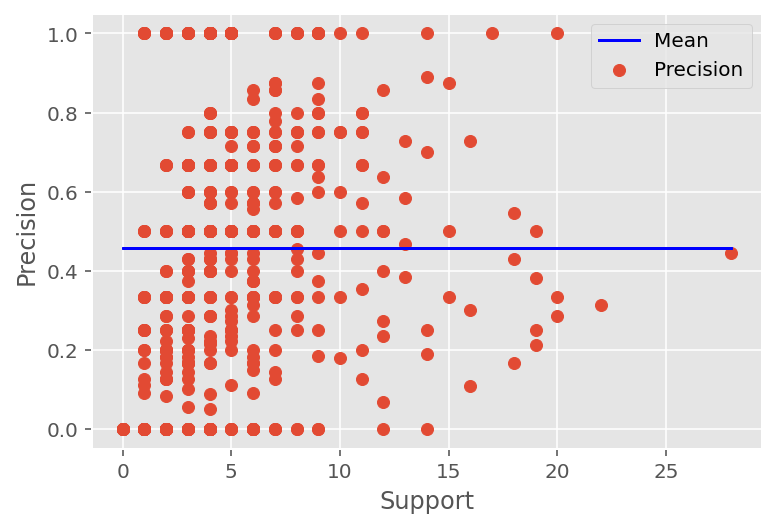

In [222]:
plt.plot(cr.support, [precision_avg for i in cr.support], '-b', label='Mean')
plt.scatter(x=cr.support, y=cr.precision, label='Precision')

plt.xlabel('Support')
plt.ylabel('Precision')
plt.legend()
plt.show()

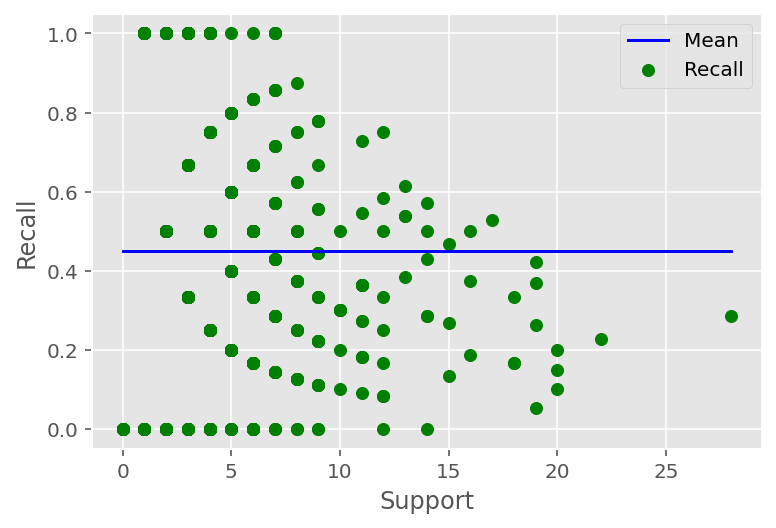

In [223]:
plt.plot(cr.support, [recall_avg for i in cr.support], '-b', label='Mean')
plt.scatter(x=cr.support, y=cr.recall, color='g', label='Recall')
plt.xlabel('Support')
plt.ylabel('Recall')
plt.legend()
plt.show()

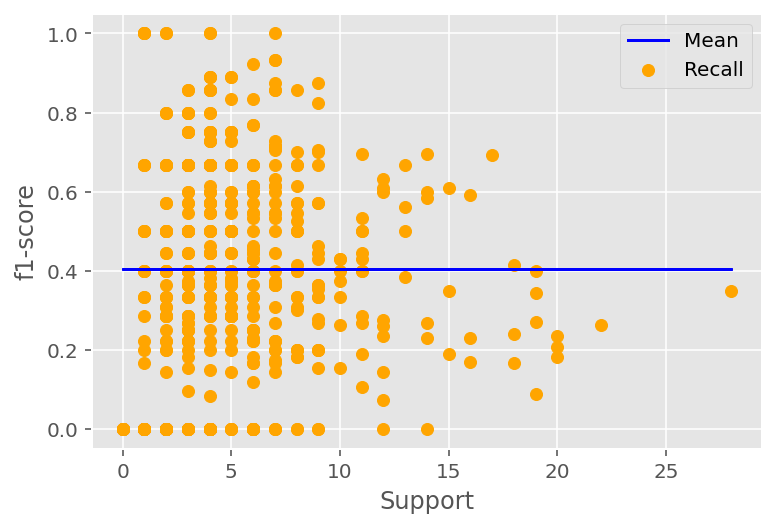

In [230]:
plt.plot(cr.support, [f1_avg for i in cr.support], '-b', label='Mean')
plt.scatter(x=cr.support, y=cr['f1-score'], color='orange', label='Recall')
plt.xlabel('Support')
plt.ylabel('f1-score')
plt.legend()
plt.show()

In [231]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

labels = labels=np.unique(y_test)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_hat, labels=labels), 
                        index=labels, 
                        columns=labels)

In [232]:
conf_mat

,1,10,12,13,1984,2,24,3,4,5,...,woodrow wilson,woody allen,world war i,wuthering heights,wyoming,yale,yellow,zachary taylor,zeus,zimbabwe
1,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1984,0,0,0,0,4,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yale,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
yellow,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
zachary taylor,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
zeus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


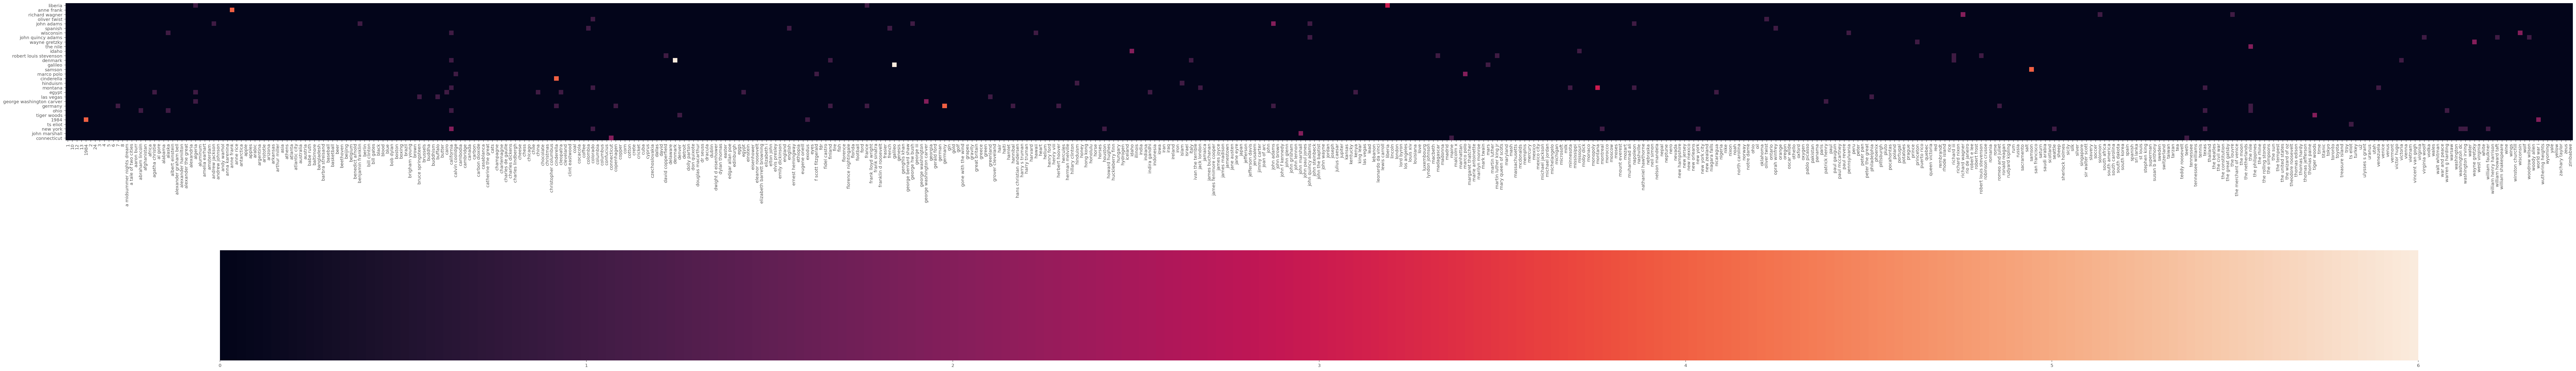

In [233]:
from seaborn import heatmap

plt.figure(figsize=(100,30))
heatmap(conf_mat.sample(n=30), square=True, cbar_kws={"orientation": "horizontal"})
plt.show()

In [68]:
# Drop vectors from test df now
test = test.loc[:, "original_answer":"original_question"]
test['class_label'] = y_hat

correct = test[test.original_answer == test.class_label]
incorrect = test[test.original_answer != test.class_label]

In [247]:
incorrect.loc[6]

original_answer                                                 russia
original_question    after the czar was overthrown in 1917 finland ...
class_label                                            peter the great
Name: 6, dtype: object

In [240]:
incorrect.loc[2971].original_question

'people in this south american city were upset by a simpsons episode showing street kids  monkeys there'

In [251]:
correct.loc[86].original_question

'plain bitter or unsweetened this contains about 50 cocoa butter  if stored properly will keep for years'

# Future work

The nature of using bag of words on this large of a vocabulary means that I have very sparse vector representations. SciPy has a datatype that works very well for this format (`csr_matrix`), but this is incompatible with most of the machine learning algorithms provided in scikit-learn. In the future, I would really like to implement a classification algorithm by hand that supports `csr_matrix` natively because I expect this will rapidly improve runtime. 

Similarly, the high cost of computation using large vectors limited my ability to compare my model against other models (support-vector machines, cosine similarity, soft cosines, etc.), so this is something I would like to explore in detail.

My accuracy hovers around 40% for this model, which isn't great (some of the best players have been more than 95% accurate). I want to explore different libraries for word lemmatization that perform better on unknown parts of speech. In addition, evaluating the performance of other models could help me choose a model that is possibly more accurate. 

While my sample size was fairly large (>200k samples), there are many questions that are archived online that I could use for training. I'm interested in writing a text mining program that can extract these questions and create a high quality dataset for future training. 

Finally, my goal for this project was to report probabilistic results (i.e., my model is 60% certain that a clue belongs to class X), but this is out of scope. There are other algorithms and paradigms that I can explore to come up with better results, perhaps a decision tree or random forest. 

With more time and effort, I can hopefully turn this model into a useful dashboard that can answer (with some degree of certainty) trivia questions from a show like Jeopardy.